<a href="https://colab.research.google.com/github/Swathi1309/ED18B034_ME18B133_CS6910/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import numpy as np
import tensorflow
from tensorflow import keras
from keras import Model
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
import tarfile
import random

In [ ]:
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback
wandb.init(project="CS6910-assg3", entity="narendv")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Data

In [ ]:

my_tar = tarfile.open('/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0.tar')
my_tar.extractall('/content/drive/MyDrive/Dakshina dataset') # specify which folder to extract to
my_tar.close()

Examples

In [8]:
import csv
hi_to_eng = open("/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
read_tsv = csv.reader(hi_to_eng, delimiter="\t")
i=0
for row in read_tsv:
  i +=1
  print(row)
  if i==30:
    break
hi_to_eng.close()

['अं', 'an', '3']
['अंकगणित', 'ankganit', '3']
['अंकल', 'uncle', '4']
['अंकुर', 'ankur', '4']
['अंकुरण', 'ankuran', '3']
['अंकुरित', 'ankurit', '3']
['अंकुश', 'aankush', '1']
['अंकुश', 'ankush', '3']
['अंग', 'ang', '2']
['अंग', 'anga', '1']
['अंगद', 'agandh', '1']
['अंगद', 'angad', '2']
['अंगने', 'angane', '3']
['अंगभंग', 'angbhang', '3']
['अंगरक्षक', 'angarakshak', '1']
['अंगरक्षक', 'angrakshak', '2']
['अंगारा', 'angara', '3']
['अंगारे', 'angaare', '1']
['अंगारे', 'angare', '2']
['अंगी', 'angi', '3']
['अंगीकार', 'angikar', '3']
['अंगुठे', 'anguthe', '3']
['अंगुल', 'angul', '3']
['अंगुलियों', 'anguliyon', '3']
['अंगुली', 'anguli', '2']
['अंगुली', 'ungli', '1']
['अंगूठा', 'angutha', '3']
['अंगूठियों', 'aanguthiyon', '1']
['अंगूठियों', 'anguthiyon', '2']
['अंगूठी', 'anguthi', '3']


In [7]:
  # Number of samples to train on.
# Path to the data txt file on disk.
data_path_train = "/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
data_path_dev = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'

In [93]:
def load_inputs(data_path,data):
  # Vectorize the data.
  input_texts = []
  target_texts = []
  input_characters = set()
  target_characters = set()
  with open(data_path, "r", encoding="utf-8") as f:
      lines = f.read().split("\n")
  for line in lines[: (len(lines) - 1)]:
      input_text, target_text, _ = line.split("\t")
      # We use "tab" as the "start sequence" character
      # for the targets, and "\n" as "end sequence" character.
      target_text = "\t" + target_text + "\n"
      input_texts.append(input_text)
      target_texts.append(target_text)
      for char in input_text:
          if char not in input_characters:
              input_characters.add(char)
      for char in target_text:
          if char not in target_characters:
              target_characters.add(char)

  input_characters = sorted(list(input_characters))
  target_characters = sorted(list(target_characters))
  num_encoder_tokens = len(input_characters)
  num_decoder_tokens = len(target_characters)
  max_encoder_seq_length = max([len(txt) for txt in input_texts])
  max_decoder_seq_length = max([len(txt) for txt in target_texts])

  # print("Number of samples:", len(input_texts))
  # print("Number of unique input tokens:", num_encoder_tokens)
  # print("Number of unique output tokens:", num_decoder_tokens)
  # print("Max sequence length for inputs:", max_encoder_seq_length)
  # print("Max sequence length for outputs:", max_decoder_seq_length)

  input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
  target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
  if data == 'train':
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
  if data == 'dev':
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, input_token_train), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, output_token_train), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, output_token_train), dtype="float32"
    )
  
  random.seed(0)
  temp = list(zip(input_texts, target_texts))
  random.shuffle(temp)
  it, tt = zip(*temp)
  
  for i, (input_text, target_text) in enumerate(zip(it, tt)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t, input_token_index[char]] = 1.0
      # encoder_input_data[i, (t + 1):, input_token_index[" "]] = 1.0
      for t, char in enumerate(target_text):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t, target_token_index[char]] = 1.0
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      # decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
      # decoder_target_data[i, t:, target_token_index[" "]] = 1.0

  return encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens, num_decoder_tokens

In [94]:
global enc_input_train, dec_input_train, dec_target_train, input_token_train, output_token_train
global enc_input_dev, dec_input_dev, dec_target_dev
enc_input_train, dec_input_train, dec_target_train, input_token_train, output_token_train = load_inputs(data_path_train,'train')
enc_input_dev, dec_input_dev, dec_target_dev, _, _ = load_inputs(data_path_dev,'dev')

In [103]:
def encoder(enc_out,in_token_no,enc_block, latent_dim):
  for i in range(0,1):
    if enc_block =='LSTM':
      enc_out ,h ,c = LSTM(latent_dim, return_state=True, return_sequences=True)(enc_out)
      s = [h,c]
    elif enc_block =='GRU':
      enc_out ,s = GRU(latent_dim, return_state=True, return_sequences=True)(enc_out)
    else:
      enc_out ,s = SimpleRNN(latent_dim, return_state=True, return_sequences=True)(enc_out)
    
  return enc_out,s


In [98]:
def decoder(X_input_dec, hs_init, latent_dim, out_token_no, dec_block,dense_no,drop_no):
  

  if dec_block == 'LSTM':
    out_dec, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(X_input_dec, initial_state = hs_init)
  elif dec_block == 'GRU':
    out_dec, _ = GRU(latent_dim, return_sequences=True, return_state=True)(X_input_dec, initial_state = hs_init)
  else:
    out_dec, _ = SimpleRNN(latent_dim, return_sequences=True, return_state=True)(X_input_dec, initial_state = hs_init)
  
  out_dec = Dense(dense_no/2, activation='tanh')(out_dec)
  out_dec = Dropout(drop_no)(out_dec)
  out_dec = Dense(out_token_no, activation="softmax")(out_dec)

  return out_dec

In [99]:
def RNN_model(in_token_no, enc_block, latent_dim, out_token_no, dec_block,dense_no,drop_no):
  X_input_enc = keras.Input(shape=(None, in_token_no))
  X_input_dec = keras.Input(shape=(None, out_token_no))
  _,s_init = encoder(X_input_enc,in_token_no,enc_block,latent_dim)
  out_dec = decoder(X_input_dec,s_init,latent_dim, out_token_no, dec_block, dense_no,drop_no)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec)

  return model

In [100]:
enc_out = keras.Input(shape=(None, input_token_train))
out=encoder(enc_out,input_token_train,'LSTM', 512)
tf.shape(out)

NameError: ignored

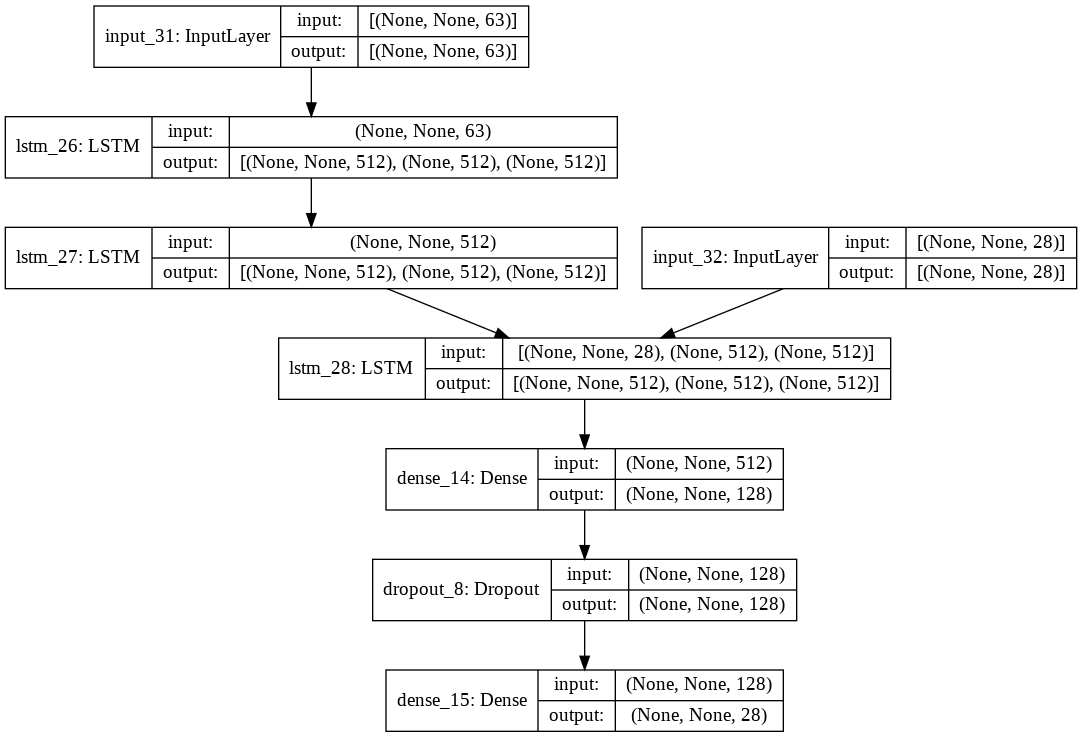

In [101]:
lat_dim=512
model = RNN_model(input_token_train,'LSTM',lat_dim,output_token_train,'LSTM', 256,0)
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
def enc_inference(model):
  X_in_enc = model.input[0]
  enc_out ,h ,s = model.layers[2].output
  X_out_enc = [h,s]
  enc_model = keras.Model(inputs = X_in_enc, outputs = X_out_enc)

  return enc_model

def dec_inference(model):
  dec_inputs = model.input[1]
  dec_input_h = keras.Input(shape=(latent_dim,))
  dec_input_s = keras.Input(shape=(latent_dim,))
  hs_inputs = [dec_input_h,dec_input_s]
  dec_model = model.layers[3]
  dec_outputs, h_dec, s_dec = dec_model(dec_inputs, initial_state=hs_inputs)
  hs_outputs = [h_dec, s_dec]
  dec_dense = model.layers[4]
  dec_outputs = dec_dense(dec_outputs)
  dec_model = keras.Model(inputs = [dec_inputs] + hs_inputs, outputs = [decoder_outputs]
                              + hs_outputs)
  
  return dec_model

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [104]:
# model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics='accuracy')
model.fit([enc_input_train,dec_input_train], dec_target_train,
          batch_size = 64,epochs=40, validation_data=([enc_input_dev,dec_input_dev], dec_target_dev))

Epoch 1/40
691/691 [==============================] - 14s 20ms/step - loss: 0.0687 - accuracy: 0.3440 - val_loss: 1.7601 - val_accuracy: 0.1122
Epoch 2/40
691/691 [==============================] - 14s 20ms/step - loss: 0.0673 - accuracy: 0.3443 - val_loss: 1.7725 - val_accuracy: 0.1106
Epoch 3/40
691/691 [==============================] - 14s 20ms/step - loss: 0.0661 - accuracy: 0.3446 - val_loss: 1.7877 - val_accuracy: 0.1085
Epoch 4/40
691/691 [==============================] - 14s 20ms/step - loss: 0.0654 - accuracy: 0.3448 - val_loss: 1.7691 - val_accuracy: 0.1104
Epoch 5/40
691/691 [==============================] - 14s 20ms/step - loss: 0.0641 - accuracy: 0.3451 - val_loss: 1.8109 - val_accuracy: 0.1087
Epoch 6/40
691/691 [==============================] - 14s 20ms/step - loss: 0.0637 - accuracy: 0.3452 - val_loss: 1.7869 - val_accuracy: 0.1101
Epoch 7/40
691/691 [==============================] - 14s 20ms/step - loss: 0.0633 - accuracy: 0.3453 - val_loss: 1.7981 - val_accuracy:

In [ ]:
import pprint

In [ ]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'encoder_block':{
        'values': ['LSTM']
      },
    # 'encoder_layers': {
    #     'values': [1,2,3]
    #   },
    'decoder_block':{
      'values' : ['LSTM']
      },
    # 'decoder_layers': {
    #     'values': [1,2,3]
    #   },
    'latent_dimension': {
        'values': [256]
      },
    'hidden_layer': {
        'values': [128]
      },
    'dropout': {
        'values': [0]
      },
    'epochs' : {
        'values' : [60]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def training_sweep(config=None):
    with wandb.init(config=config):
        print(input_token_train)
        config = wandb.config
        print(output_token_train)
        model = RNN_model(input_token_train, config.encoder_block, config.latent_dimension, output_token_train, config.decoder_block,  config.hidden_layer, config.dropout)
        print('lol')
        model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics='accuracy')
        print('lol')
        history = model.fit([enc_input_train,dec_input_train], dec_target_train, 
                            epochs=config.epochs,
                            validation_data = ([enc_input_dev,dec_input_dev], dec_target_dev),
                            callbacks = [WandbCallback()]
                            )
        print('lol')
        # name = str(config.encoder_block) + '_' + str(config.encoder_layers) + '_' + str(config.decoder_block) + '_' + str(config.decoder_layers) + '_' + str(config.hidden_layer) + '_' + str(config.dropout) + '_' + str(config.epochs)
        # location = '/content/drive/MyDrive/Transliteration/' + name
        # model.save(location)

{'method': 'grid',
 'parameters': {'decoder_block': {'values': ['LSTM']},
                'dropout': {'values': [0]},
                'encoder_block': {'values': ['LSTM']},
                'epochs': {'values': [60]},
                'hidden_layer': {'values': [128]},
                'latent_dimension': {'values': [256]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="CS6910-assg3")
wandb.agent(sweep_id, training_sweep)

Create sweep with ID: bes2wpdh
Sweep URL: https://wandb.ai/narendv/CS6910-assg3/sweeps/bes2wpdh


wandb: Agent Starting Run: h4d1mleg with config:
wandb: 	decoder_block: LSTM
wandb: 	dropout: 0
wandb: 	encoder_block: LSTM
wandb: 	epochs: 60
wandb: 	hidden_layer: 128
wandb: 	latent_dimension: 256


63
28
lol
lol
Epoch 1/60
1382/1382 [==============================] - 16s 9ms/step - loss: 0.9539 - accuracy: 0.1051 - val_loss: 1.1106 - val_accuracy: 0.1125
Epoch 2/60
1382/1382 [==============================] - 12s 9ms/step - loss: 0.5539 - accuracy: 0.2062 - val_loss: 1.4016 - val_accuracy: 0.0769
Epoch 3/60
1382/1382 [==============================] - 12s 9ms/step - loss: 0.3737 - accuracy: 0.2605 - val_loss: 1.5165 - val_accuracy: 0.0789
Epoch 4/60
1382/1382 [==============================] - 12s 9ms/step - loss: 0.2665 - accuracy: 0.2919 - val_loss: 1.5546 - val_accuracy: 0.0883
Epoch 5/60
1382/1382 [==============================] - 12s 9ms/step - loss: 0.2093 - accuracy: 0.3084 - val_loss: 1.5771 - val_accuracy: 0.0901
Epoch 6/60
1382/1382 [==============================] - 12s 9ms/step - loss: 0.1765 - accuracy: 0.3188 - val_loss: 1.5795 - val_accuracy: 0.0923
Epoch 7/60
1382/1382 [==============================] - 12s 9ms/step - loss: 0.1558 - accuracy: 0.3239 - val_loss: 1

epoch,59
loss,0.1043
accuracy,0.33862
val_loss,1.72374
val_accuracy,0.08725
_runtime,737
_timestamp,1619806325
_step,59
best_val_loss,1.11063
best_epoch,0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▇▇▇██████████████████████████████████
val_loss,▁▄▆▆▆▇▆▇▇▇▇█▇██▇██▇███████████▇▇▇█▇▇▇█▇▇
val_accuracy,█▁▃▄▄▄▅▅▅▅▄▄▅▅▅▅▅▅▅▅▄▄▅▄▄▄▄▄▄▄▄▄▄▃▃▄▃▃▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
